In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.io import json
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import preprocessing

datasetJSONPath = os.getcwd() + "\\datasets\\empire_monologue_netntlm_downgrade_2019-12-25045202.json"
df = json.read_json(path_or_buf=datasetJSONPath, lines=True)

df.shape

C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\ly\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


(1635, 151)

In [2]:
# functions definition

from collections import Counter
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

# Convert integers to strings
def int_to_str(df):
    for column in df.columns:
        # if dtype is int, convert to string , e.g. EventID
        if isinstance(df[column][0], (int, np.int32, np.int64)):
            df[column] = list(map(str, df[column]))
            
    return df
    
# Count NaN in each column in the dataframe
def count_nan(df):
    for column in df.columns:
        num = df[column].isna().sum()
        print(column, str(num))
    return 0

# make a label list of all 0, except the detected threat are 1
def labelList(num, threatIndices):
    y = [0 for x in range(num)]
    for i in threatIndices:
        y[i] =  1
    return y

# Count the items in data frame
def count_items(df):
    for column in df.columns:
        item = df[column]
        print(column, ": ", sorted(Counter(item).items()))
        
    return 0

# replicate specified data to the end of the dataset
def pd_replicate(X, y, rep_list, times=1):
    for index in rep_list:
        for i in range(times):
            
            X = pd.concat([X, pd.DataFrame(X.iloc[index]).T], axis=0, ignore_index=True)

            y.append(1)
    
    return (X, y)
    
# convert object items in the list into strings
def preprocess(df):
    
    # replace NAN with 0
    df = df.replace(np.nan, 0, regex=True)
    
    for column in df.columns:            
        df[column] = list(map(str, df[column]))            
    return df

# fit the dataframe and record the label encoders for each column
def labelEncoder_get(df):
#     le_list = []
    le_dict = {}
    for column in df.columns:
        le = preprocessing.LabelEncoder()
        le.fit(df[column])
        df[column] = le.transform(df[column])
#         le_list.append(le)
        le_dict[column] = le
    return (df, le_dict)

# input the list of label encoders and transform the dataframe
def labelEncoder_trans(df, le_dict):
    for i, column in enumerate(df.columns):
#         le = le_list[i]
        le = le_dict[column]
        df[column] = list(map(str, df[column]))
        df[column] = le.transform(df[column])
    return df

# draw confusin matrix and print the classification report
def draw_confusionMatrix(y_test, y_predict):
    confusion_matrix = metrics.confusion_matrix(y_test, y_predict)
    matrix_df = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sns.set(font_scale=1.3)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="magma")
    ax.set_title('Confusion Matrix - Decision Tree')
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_ylabel("Actual Label", fontsize=15)
    plt.show()
    print(metrics.classification_report(y_test, y_predict))
    

# Randomly pick data from results and combine them
def random_generator(data_list, pick_nums):
    
    generated_data = pd.DataFrame()
    
    for i, data in enumerate(data_list):
        num = pick_nums[i]
        data_selected = data.sample(num)
        generated_data = pd.concat([generated_data, data_selected], axis=0, ignore_index=True)
    
    return generated_data
    

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
features = ["Channel", "EventID", "ObjectType", "ObjectName", "ProcessName", "SubjectLogonId", "ObjectValueName", "TargetObject"]
df = df[features]

# change integers to strings to get a better performance in generating new data
df = int_to_str(df)
df.shape

(1635, 8)

## Replicate positive data

There are more negative data than positive data, and results from some analytics (e.g. analytics with merging) are less possible to be generated. So we replicate specific positive data to make CTGAN bias to them.

## Use CTGAN to generate new data

In [4]:
from sdv.tabular import CTGAN

# model = CTGAN(cuda=True)
# model.fit(df)

# save and reuse the model
# model.save('RegModExtendedNetNTLMDowngrade.pkl')

model = CTGAN.load(r'models\\RegModExtendedNetNTLMDowngrade.pkl')

In [5]:
new_data = model.sample(num_rows=1000000)
new_data.head()

,Channel,EventID,ObjectType,ObjectName,ProcessName,SubjectLogonId,ObjectValueName,TargetObject
0,Windows PowerShell,12,NaN,NaN,C:\Windows\System32\lsass.exe,NaN,LMCompatibilityLevel,NaN
1,Security,4103,NaN,NaN,NaN,NaN,NaN,HKLM\System\CurrentControlSet\Services\DFSR\Pa...
2,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,NaN,NaN,NaN,NaN
3,security,13,NaN,NaN,NaN,NaN,NtlmMinClientSec,NaN
4,Microsoft-Windows-Sysmon/Operational,10,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# # for debugging only
# count_items(preprocess_labelEncoder(df))
# count_items(preprocess_labelEncoder(new_data))

## Use hunter program on new data

In [6]:
# Analytic I
I = (
new_data[["Channel", "EventID", "ObjectType", "ObjectName", "ProcessName", "SubjectLogonId", "ObjectValueName", "TargetObject"]]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'].isin(['4663','4656']))
    & (new_data['ObjectType'] == 'Key')
    & (
      (new_data['ObjectName'].str.lower().str.endswith('lsa', na=False))
      | (new_data['ObjectName'].str.lower().str.endswith('lsa\msv1_0', na=False))
    )
    & (~new_data['ProcessName'].str.lower().str.endswith('lsass.exe', na=False))
    & (new_data['SubjectLogonId'] != '0x3e7')
]
)
I

,Channel,EventID,ObjectType,ObjectName,ProcessName,SubjectLogonId,ObjectValueName,TargetObject
87,Security,4656,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,-,0x0,NaN,NaN
180,security,4656,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x49631,NaN,NaN
263,security,4656,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x73f729,NaN,NaN
368,security,4663,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,-,0x49631,NaN,NaN
598,security,4663,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x49631,NaN,NaN
...,...,...,...,...,...,...,...,...
999586,Security,4663,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\svchost.exe,0x49631,NaN,NaN
999653,security,4656,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,NaN,NaN,NaN
999864,security,4656,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,NaN,0x49631,NaN,NaN
999923,security,4656,Key,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x49631,NaN,NaN


In [7]:
# Analytic II
II  = (
new_data[["Channel", "EventID", "ObjectType", "ObjectName", "ProcessName", "SubjectLogonId", "ObjectValueName", "TargetObject"]]

[(new_data['Channel'].str.lower() == 'security')
    & (new_data['EventID'] == '4657')
    & (new_data['ObjectValueName'].isin(['LMCompatibilityLevel','NtlmMinClientSec','RestrictSendingNTLMTraffic']))
]
)
II

,Channel,EventID,ObjectType,ObjectName,ProcessName,SubjectLogonId,ObjectValueName,TargetObject
34,security,4657,Key,Policy\Secrets\$MACHINE.ACC,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x49631,RestrictSendingNTLMTraffic,NaN
267,security,4657,NaN,NaN,C:\Windows\System32\lsass.exe,0x3e7,NtlmMinClientSec,NaN
328,security,4657,NaN,NaN,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x3e5,RestrictSendingNTLMTraffic,NaN
457,security,4657,NaN,NaN,NaN,NaN,RestrictSendingNTLMTraffic,NaN
581,security,4657,SecretObject,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x49631,NtlmMinClientSec,NaN
...,...,...,...,...,...,...,...,...
999688,Security,4657,NaN,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\WindowsPowerShell\v1.0\pow...,0x3e5,RestrictSendingNTLMTraffic,NaN
999703,security,4657,NaN,NaN,NaN,NaN,RestrictSendingNTLMTraffic,NaN
999732,security,4657,NaN,NaN,NaN,NaN,RestrictSendingNTLMTraffic,NaN
999800,security,4657,NaN,NaN,C:\Windows\System32\lsass.exe,NaN,NtlmMinClientSec,NaN


In [8]:
# Analytic III
III  = (
new_data[["Channel", "EventID", "ObjectType", "ObjectName", "ProcessName", "SubjectLogonId", "ObjectValueName", "TargetObject"]]

[(new_data['Channel'] == 'Microsoft-Windows-Sysmon/Operational')
    & (new_data['EventID'] == '13')
    & (
      (new_data['TargetObject'].str.endswith('LMCompatibilityLevel', na=False))
      | (new_data['TargetObject'].str.endswith('NtlmMinClientSec', na=False))
      | (new_data['TargetObject'].str.endswith('RestrictSendingNTLMTraffic', na=False))
    )
]
)
III

,Channel,EventID,ObjectType,ObjectName,ProcessName,SubjectLogonId,ObjectValueName,TargetObject
2889,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,RestrictSendingNTLMTraffic,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
4313,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,RestrictSendingNTLMTraffic,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
6021,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,NaN,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
10673,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,-,0x3e7,RestrictSendingNTLMTraffic,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
14050,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,0x49631,RestrictSendingNTLMTraffic,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
...,...,...,...,...,...,...,...,...
929494,Microsoft-Windows-Sysmon/Operational,13,NaN,\REGISTRY\MACHINE\SYSTEM\ControlSet001\Control...,C:\Windows\System32\lsass.exe,NaN,RestrictSendingNTLMTraffic,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
934647,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,0x73f729,NaN,HKLM\System\CurrentControlSet\Control\Lsa\MSV1...
953194,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,NaN,HKLM\System\CurrentControlSet\Control\Lsa\LMCo...
959363,Microsoft-Windows-Sysmon/Operational,13,NaN,NaN,NaN,NaN,NaN,HKLM\System\CurrentControlSet\Control\Lsa\LMCo...


### Generate data
Randomly pick data from each analytic's results, and combine them as the generated dataset.

In [9]:
# randomly pick from results of analytics
results = [I, II, III]
pick_nums = [400, 400, 118]
gen_data = random_generator(results, pick_nums)

gen_data.shape

(918, 8)

## Decision Tree

### Preprocess data

In [28]:
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df = scaler.fit_transform(df)

### Original data

Balanced accuracy score: 1.00


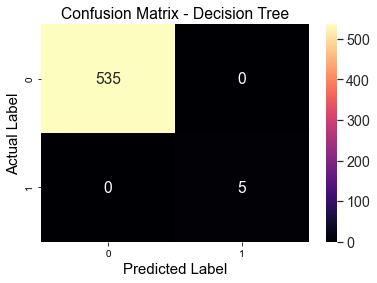

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       535
           1       1.00      1.00      1.00         5

    accuracy                           1.00       540
   macro avg       1.00      1.00      1.00       540
weighted avg       1.00      1.00      1.00       540



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# X = preprocess_labelEncoder(df)
X = preprocess(df)
X, le_dict = labelEncoder_get(X)
y = labelList(df.shape[0], [550, 552, 553, 556, 581, 589, 592, 601, 642, 651, 655, 665, 564, 579, 591, 611, 615, 376, 504, 505, 546, 549])

clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

Got good performance by only using the original dataset, there's no requirement to generate fake data.

### Original data with generated data
Generated data should only be added into trianing set.

Balanced accuracy score: 1.00


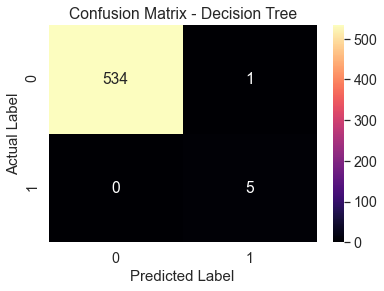

<Figure size 720x504 with 0 Axes>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       535
           1       0.83      1.00      0.91         5

    accuracy                           1.00       540
   macro avg       0.92      1.00      0.95       540
weighted avg       1.00      1.00      1.00       540



In [12]:
X_gen = preprocess(gen_data)
X_gen = labelEncoder_trans(X_gen, le_dict)
# add generated data to the original training set
X_train_new = pd.concat([X_train, X_gen], axis=0)

# generated data are all positive
for i in range(len(gen_data)):
    y_train.append(1)

clf = DecisionTreeClassifier()

clf.fit(X_train_new, y_train)
y_predict = clf.predict(X_test)
print("Balanced accuracy score: {:.2f}".format(metrics.balanced_accuracy_score(y_test, y_predict)))
draw_confusionMatrix(y_test, y_predict)

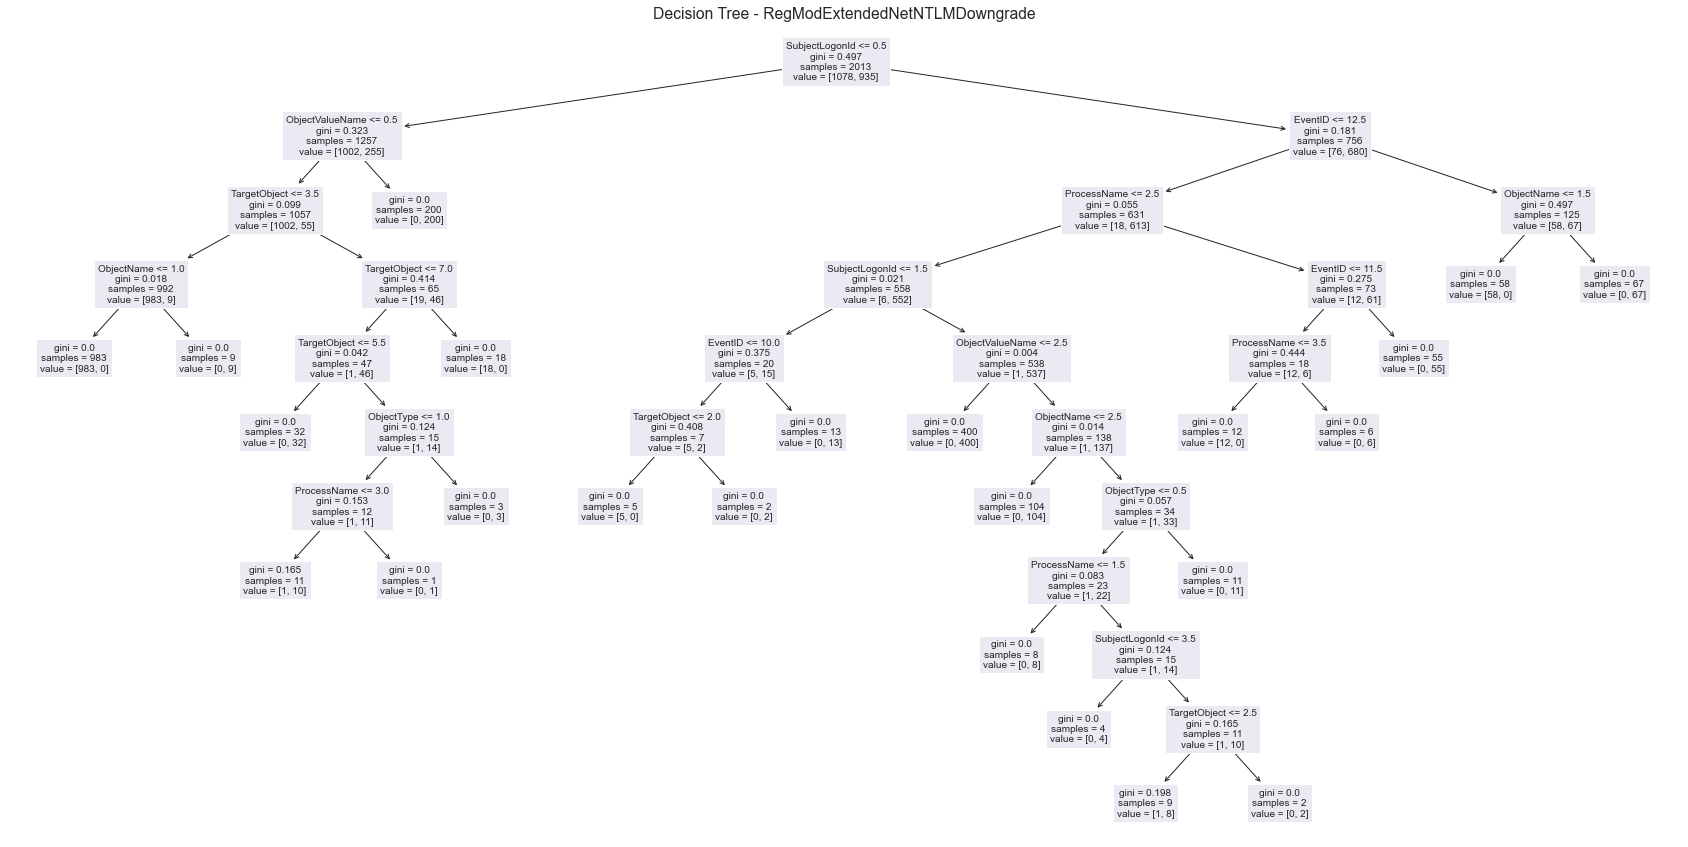

In [14]:
# draw the tree
from sklearn import tree

plt.figure(figsize=(30, 15))
tree.plot_tree(clf, feature_names=features, fontsize=10)
plt.title("Decision Tree - RegModExtendedNetNTLMDowngrade")
plt.savefig(r'DecisionTree\RegModExtendedNetNTLMDowngrade.png', dpi=100, transparent=True)

## Save generated data

In [15]:
# # extract to JSON file
# dataset.reset_index(drop=True, inplace=True)
gen_data.to_json(os.getcwd() + r'\generated_datasets\eempire_monologue_netntlm_downgrade_new.json', orient='records')

# dataset = json.read_json(path_or_buf=os.getcwd()+ "\\generated_datasets"+ "\\empire_dllinjection_LoadLibrary_CreateRemoteThread_new.json")
# dataset.head()